In [4]:
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt

# Code for the Ising Model using Monte Carlo Simulations

This is mostly inspired in the following Github gist: [https://rajeshrinet.github.io/blog/2014/ising-model/](https://rajeshrinet.github.io/blog/2014/ising-model/)

In [ ]:
def initialstate(N: int, rng: np.random.Generator) -> np.ndarray:
    """
    Generates a random spin configuration with equal numbers of +1 and -1
    """
    total_sites = N * N
    spins = np.ones(total_sites, dtype=int)

    
    half = total_sites // 2
    spins[:half] = -1

    rng.shuffle(spins)

    return spins.reshape(N, N)

In [ ]:
def get_energy(config: np.ndarray, periodic_bc: bool = True) -> float:
    if periodic_bc:
        E = -np.sum(config * np.roll(config, 1, axis=0))   # vertical bonds
        E += -np.sum(config * np.roll(config, 1, axis=1))  # horizontal bonds
    else:
        E = -np.sum(config[:-1, :] * config[1:, :])        # vertical bonds
        E += -np.sum(config[:, :-1] * config[:, 1:])       # horizontal bonds

    return float(E)

In [ ]:
def get_magnetization(config: np.ndarray) -> float:
    M = np.sum(config)
    return float(M)

print(get_magnetization(np.ones((4,4), dtype=int))) 

16.0


In [ ]:
def montecarlo_step(config: np.ndarray, T: float, rng: np.random.Generator, periodic_bc: bool = True):
    """
    One Metropolis update on a random site
    """

    N = config.shape[0]
    i = rng.integers(N)
    j = rng.integers(N)

    s = config[i, j]

    # Sum of the 4 nearest neighbors
    if periodic_bc:
        nn = (config[(i+1) % N, j] + config[(i-1) % N, j] +
              config[i, (j+1) % N] + config[i, (j-1) % N])
    else:
        nn = 0
        if i+1 < N: nn += config[i+1, j]
        if i-1 >= 0: nn += config[i-1, j]
        if j+1 < N: nn += config[i, j+1]
        if j-1 >= 0: nn += config[i, j-1]

    # Energy change for flipping spin
    dE = 2.0 * s * nn

    # Metropolis criterion
    if dE <= 0.0 or rng.random() < np.exp(-dE / T):
        config[i, j] = -s     
        dM = -2.0 * s         
        return True, dE, dM
    else:
        return False, 0.0, 0.0


In [ ]:
def sweep(config, T, periodic_bc=True, rng=None):
    N = config.shape[0]
    acc = 0
    dE = dM = 0.0
    for _ in range(N*N):
        a, de, dm = montecarlo_step(config, T,  rng, periodic_bc)
        acc += a    
        dE += de if a else 0.0 
        dM += dm
    return acc, dE, dM


In [ ]:
def run_experiment(size: int, T: float, steps: int, rng: np.random.Generator,
                   periodic_bc: bool = True) -> np.ndarray:
    config = initialstate(size, rng)
    E = get_energy(config, periodic_bc)
    M = get_magnetization(config)

    # Measurement
    energies = np.zeros(steps)
    magnetizations = np.zeros(steps)
    for i in range(steps):
        _, dE, dM = sweep(config, T, rng=rng,periodic_bc=periodic_bc)
        E += dE
        M += dM
        energies[i] = E
        magnetizations[i] = M

    # normalize magnetization
    magnetizations /= (size * size)
    magnetizations = np.abs(magnetizations)

    measurements = list(zip(energies, magnetizations))

    

    return np.array(measurements)

In [11]:
def plot_magnetization_vs_steps(steps, magnetizations, title = 'Magnetization vs Monte Carlo Steps'):
    plt.figure(figsize=(10, 6))
    plt.plot(steps, magnetizations, marker='o', linestyle='-', color='b')
    plt.title(title)
    plt.xlabel('Monte Carlo Steps')
    plt.ylabel('Magnetization')
    plt.ylim(0, 1)
    plt.grid(True)
    plt.show()

def plot_energy_vs_steps(steps, energies, title = 'Energy vs Monte Carlo Steps'):
    plt.figure(figsize=(10, 6))
    plt.plot(steps, energies, marker='o', linestyle='-', color='r')
    plt.title(title)
    plt.xlabel('Monte Carlo Steps')
    plt.ylabel('Energy')
    plt.grid(True)
    plt.show()

def plot_avg_energy_vs_steps(steps, energies, discard_steps=100, title = 'Average Energy vs Monte Carlo Steps'):
    energies = energies[discard_steps:]
    avg_energies = np.cumsum(energies) / np.arange(1, len(energies) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(steps[discard_steps:], avg_energies, marker='o', linestyle='-', color='g')
    plt.title(title)
    plt.xlabel('Monte Carlo Steps')
    plt.ylabel('Average Energy')
    plt.grid(True)
    plt.show()

# EX 2

In [12]:
rng = np.random.default_rng()

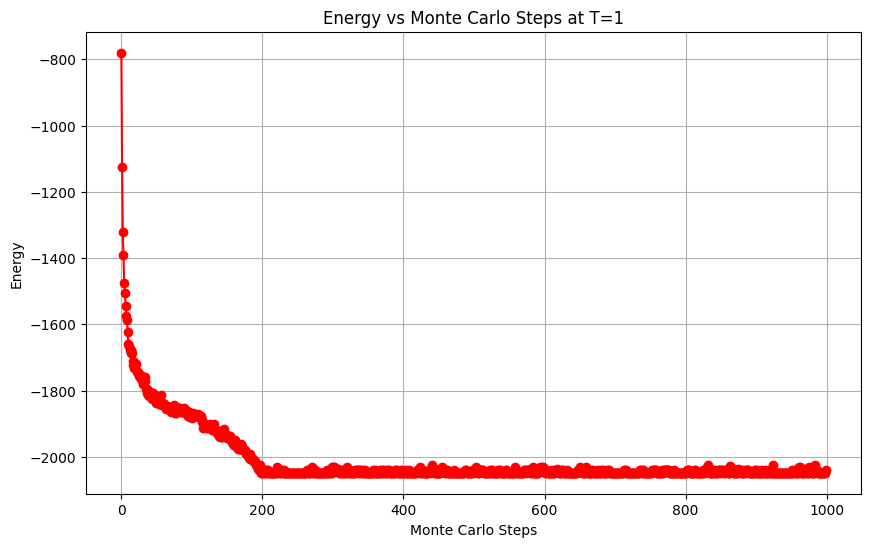

In [13]:
results = run_experiment(size=32, T=1, steps=1000, rng=rng)
# plot_magnetization_vs_steps(np.arange(1000), results[:, 1], 'Magnetization vs Monte Carlo Steps at T=1')
plot_energy_vs_steps(np.arange(1000), results[:, 0], 'Energy vs Monte Carlo Steps at T=1')

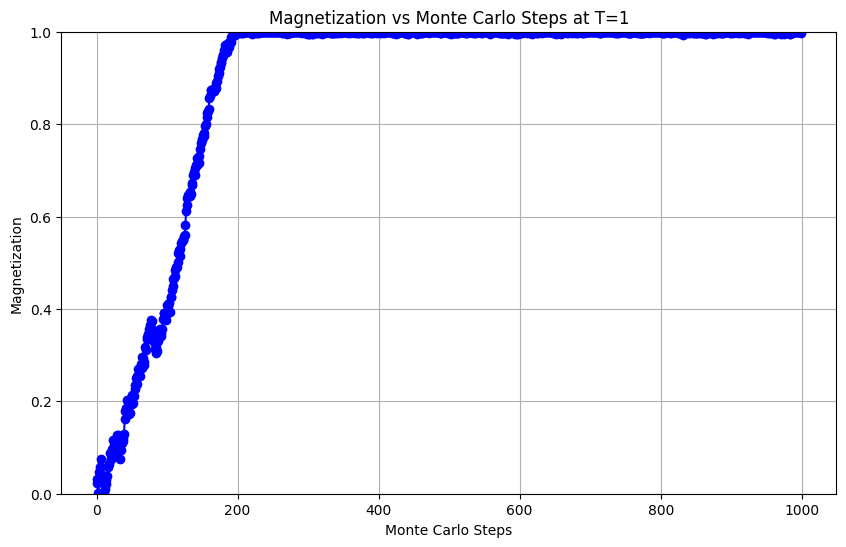

In [14]:
plot_magnetization_vs_steps(np.arange(1000), results[:, 1], 'Magnetization vs Monte Carlo Steps at T=1')

In [15]:
def get_average(series: np.array, last=None):
    if last is None:
        return np.mean(series)
    else:
        return np.mean(series[-last:])

In [16]:
avg_energy = get_average(results[:,0], last=100)
avg_magnetization = get_average(results[:,1], last=100)

print(f'Average Energy: {avg_energy}, Average Magnetization: {avg_magnetization}')

Average Energy: -2045.48, Average Magnetization: 0.999375


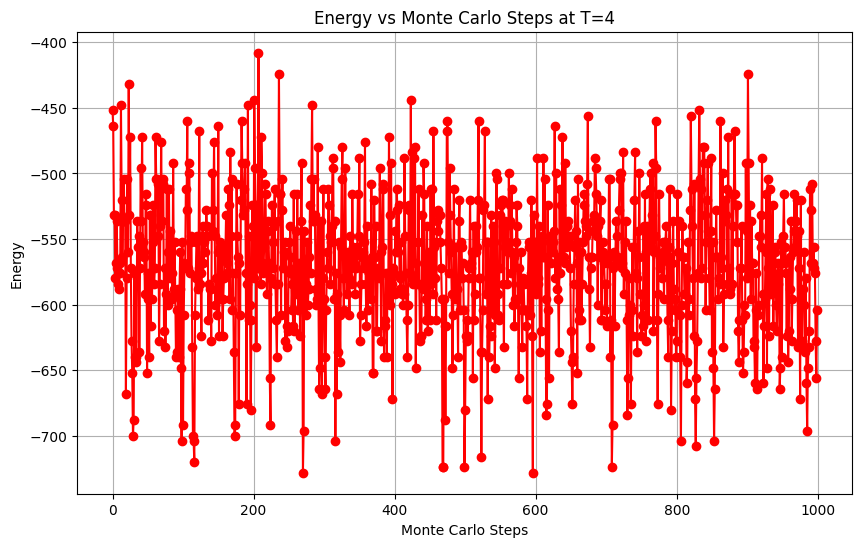

In [17]:
results = run_experiment(size=32, T=4, steps=1000, rng=rng)
# plot_magnetization_vs_steps(np.arange(1000), results[:, 1], 'Magnetization vs Monte Carlo Steps at T=4')
plot_energy_vs_steps(np.arange(1000), results[:, 0], 'Energy vs Monte Carlo Steps at T=4')

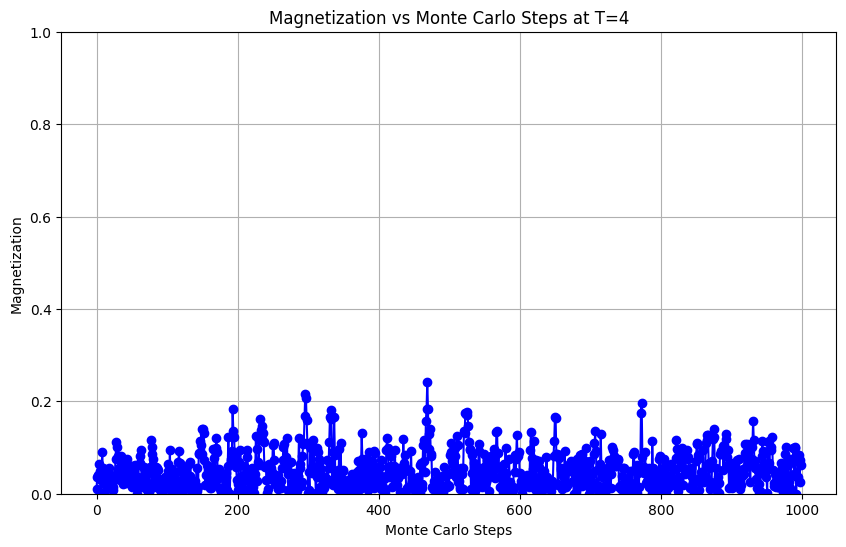

In [18]:
plot_magnetization_vs_steps(np.arange(1000), results[:, 1], 'Magnetization vs Monte Carlo Steps at T=4')

In [19]:
avg_energy = get_average(results[:,0], last=100)
avg_magnetization = get_average(results[:,1], last=100)

print(f'Average Energy: {avg_energy}, Average Magnetization: {avg_magnetization}')

Average Energy: -580.68, Average Magnetization: 0.05470703125


Obtain magnetization versus temperature, running for 20 different temperatures, going
across the phase transition. Is it better to use regularly spaced temperature values? Can you
estimate the critical temperature for your system?

In [20]:
expected_critical_point = 2.269
min_temp, max_temp = 1, 4
samples = 20

low_range = 1.75
high_range = 3

low = np.linspace(min_temp, low_range, samples//4, endpoint=False)
high = np.linspace(high_range, max_temp, samples//4, endpoint=False)
mid = np.linspace(low_range, high_range, samples//2)

temperatures = np.concatenate((low, mid, high))

temperatures

array([1.        , 1.15      , 1.3       , 1.45      , 1.6       ,
       1.75      , 1.88888889, 2.02777778, 2.16666667, 2.30555556,
       2.44444444, 2.58333333, 2.72222222, 2.86111111, 3.        ,
       3.        , 3.2       , 3.4       , 3.6       , 3.8       ])

In [21]:
magnetizations = []
steps = 1000
for T in temperatures:
    results = run_experiment(size=32, T=T, steps=steps, rng=rng)
    avg_magnetization = get_average(results[:,1], last=100)
    magnetizations.append(avg_magnetization)




KeyboardInterrupt: 

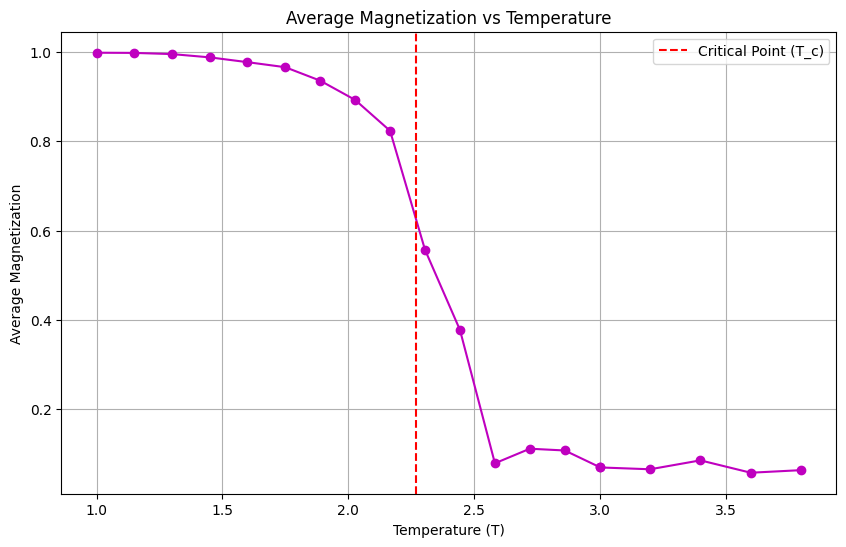

In [ ]:
# plot magnetization vs temperature
plt.figure(figsize=(10, 6))
plt.plot(temperatures, magnetizations, marker='o', linestyle='-', color='m')
plt.title('Average Magnetization vs Temperature')
plt.xlabel('Temperature (T)')
plt.ylabel('Average Magnetization')
plt.axvline(expected_critical_point, color='r', linestyle='--', label='Critical Point (T_c)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# plot the derivative of magnetization with respect to temperature
derivative = np.gradient(magnetizations, temperatures)

/home/andres/.conda/envs/.venv/lib/python3.12/site-packages/numpy/lib/function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/home/andres/.conda/envs/.venv/lib/python3.12/site-packages/numpy/lib/function_base.py:1243: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/home/andres/.conda/envs/.venv/lib/python3.12/site-packages/numpy/lib/function_base.py:1244: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/home/andres/.conda/envs/.venv/lib/python3.12/site-packages/numpy/lib/function_base.py:1250: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]


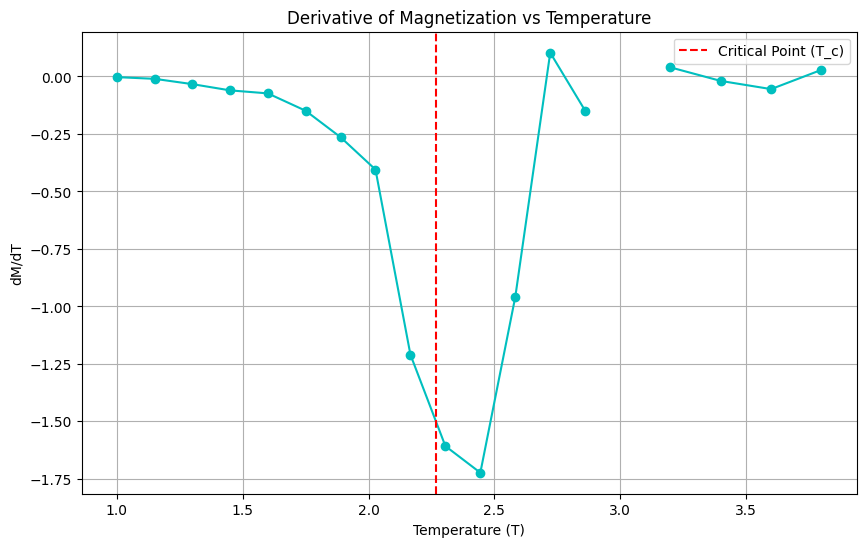

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(temperatures, derivative, marker='o', linestyle='-', color='c')
plt.title('Derivative of Magnetization vs Temperature')
plt.xlabel('Temperature (T)')
plt.ylabel('dM/dT')
plt.axvline(expected_critical_point, color='r', linestyle='--', label='Critical Point (T_c)')
plt.legend()
plt.grid(True)
plt.show()

# EX 3

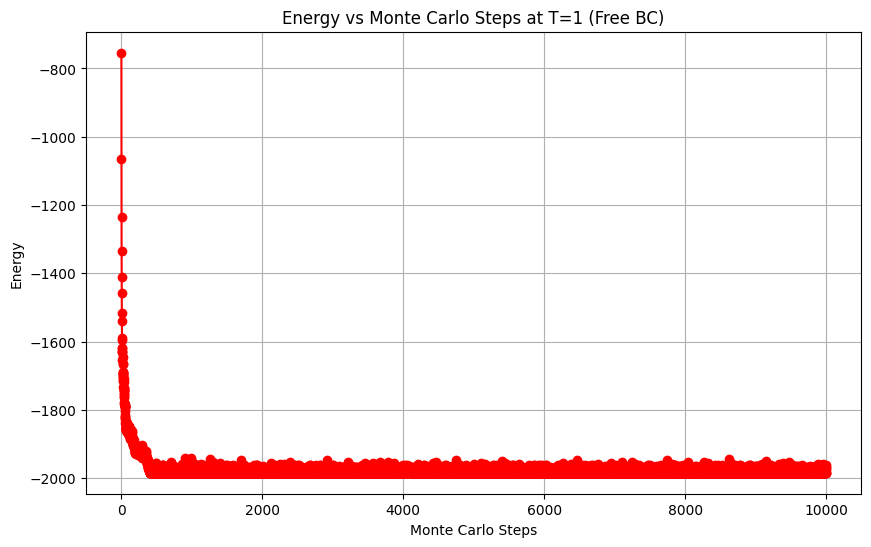

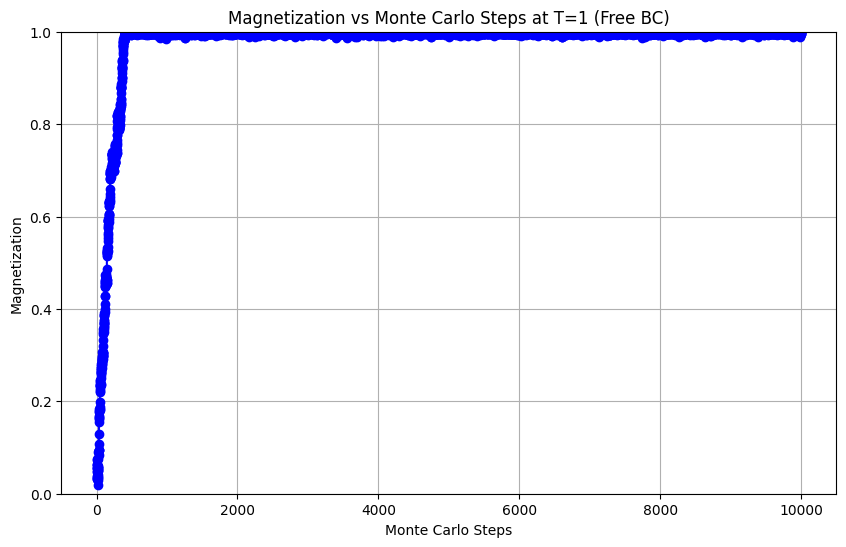

Average Energy (Free BC): -1976.82, Average Magnetization (Free BC): 0.997578125


In [ ]:
results = run_experiment(size=32, T=1, steps=10000, rng=rng, periodic_bc=False)
# plot_magnetization_vs_steps(np.arange(1000), results[:, 1], 'Magnetization vs Monte Carlo Steps at T=1')
plot_energy_vs_steps(np.arange(10000), results[:, 0], 'Energy vs Monte Carlo Steps at T=1 (Free BC)')
plot_magnetization_vs_steps(np.arange(10000), results[:, 1], 'Magnetization vs Monte Carlo Steps at T=1 (Free BC)')

avg_energy = get_average(results[:,0], last=100)
avg_magnetization = get_average(results[:,1], last=100)

print(f'Average Energy (Free BC): {avg_energy}, Average Magnetization (Free BC): {avg_magnetization}')

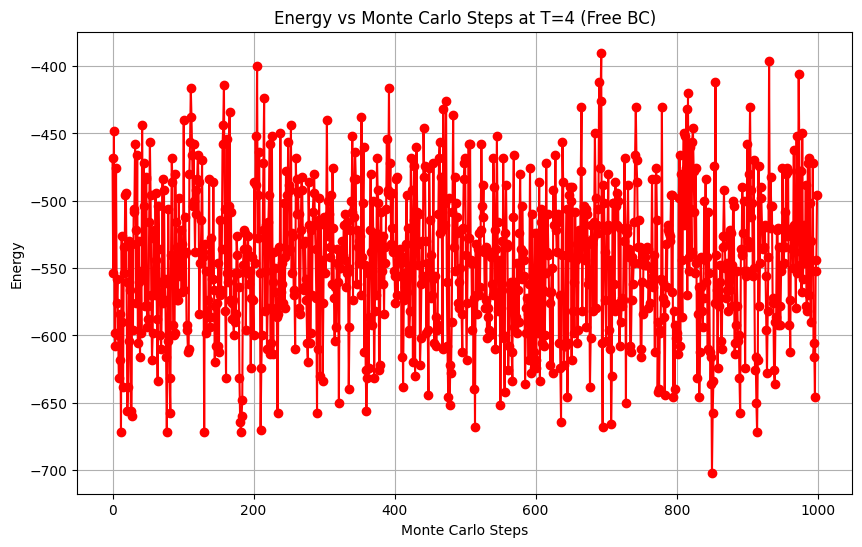

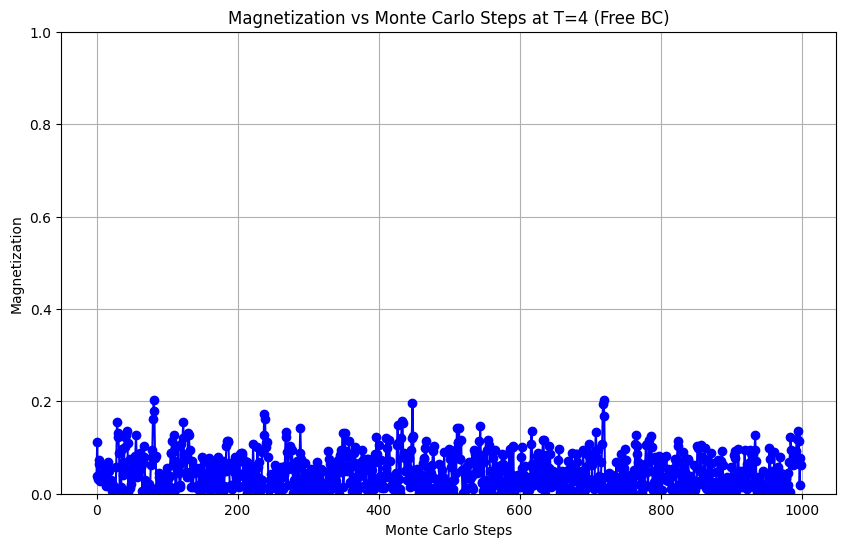

Average Energy (Free BC): -536.68, Average Magnetization (Free BC): 0.04509765625


In [ ]:
results = run_experiment(size=32, T=4, steps=1000, rng=rng, periodic_bc=False)
# plot_magnetization_vs_steps(np.arange(1000), results[:, 1], 'Magnetization vs Monte Carlo Steps at T=1')
plot_energy_vs_steps(np.arange(1000), results[:, 0], 'Energy vs Monte Carlo Steps at T=4 (Free BC)')
plot_magnetization_vs_steps(np.arange(1000), results[:, 1], 'Magnetization vs Monte Carlo Steps at T=4 (Free BC)')

avg_energy = get_average(results[:,0], last=100)
avg_magnetization = get_average(results[:,1], last=100)

print(f'Average Energy (Free BC): {avg_energy}, Average Magnetization (Free BC): {avg_magnetization}')

# EX 4

In [33]:
system_sizes = [4,8,16,32,64]
temps=[1,4]


steps = 5000

series = {}
averages = {}

rng = np.random.default_rng()

for size in system_sizes:
    for T in temps:
        print(f'Running experiment for size={size}, T={T}')
        results = run_experiment(size=size, T=T, steps=steps, rng=rng)
        avg_energy = get_average(results[:,0], last=500)
        avg_magnetization = get_average(results[:,1], last=500)
        series[(size, T)] = results
        averages[(size, T)] = (avg_energy, avg_magnetization)
        print(f'Average Energy: {avg_energy}, Average Magnetization: {avg_magnetization}')

Running experiment for size=4, T=1
Average Energy: -31.984, Average Magnetization: 0.99975
Running experiment for size=4, T=4
Average Energy: -10.608, Average Magnetization: 0.4495
Running experiment for size=8, T=1
Average Energy: -127.904, Average Magnetization: 0.999625
Running experiment for size=8, T=4
Average Energy: -36.296, Average Magnetization: 0.2043125
Running experiment for size=16, T=1
Average Energy: -511.32, Average Magnetization: 0.999328125
Running experiment for size=16, T=4
Average Energy: -140.976, Average Magnetization: 0.1096875
Running experiment for size=32, T=1
Average Energy: -2045.24, Average Magnetization: 0.9993125
Running experiment for size=32, T=4
Average Energy: -568.656, Average Magnetization: 0.04823828125
Running experiment for size=64, T=1
Average Energy: -8180.712, Average Magnetization: 0.9992978515625
Running experiment for size=64, T=4
Average Energy: -2281.4, Average Magnetization: 0.02430078125


In [40]:
import pickle

pickle.dump(series, open('ising_series.pkl', 'wb'))
pickle.dump(averages, open('ising_averages.pkl', 'wb'))

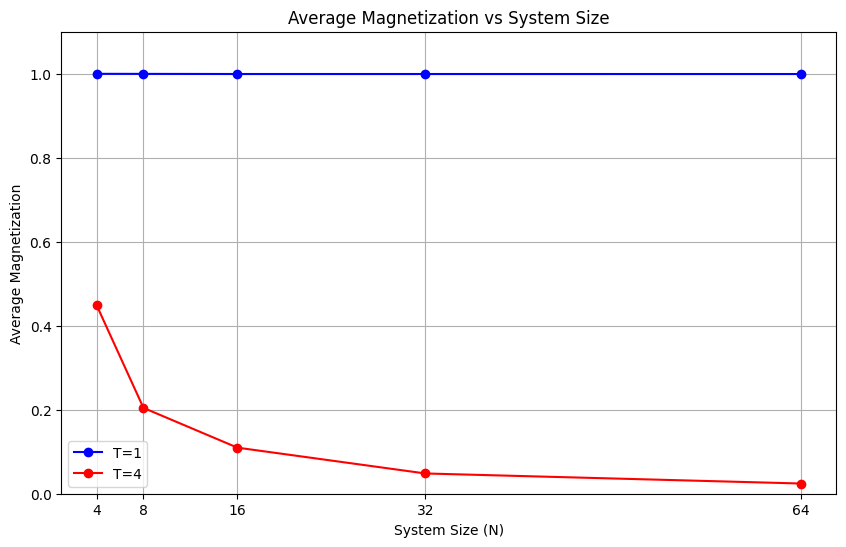

In [34]:
# plot magnetization vs system size
sizes_T1 = [size for size in system_sizes]
magnetizations_T1 = [averages[(size, 1)][1] for size in system_sizes]
sizes_T4 = [size for size in system_sizes]
magnetizations_T4 = [averages[(size, 4)][1] for size in system_sizes]

plt.figure(figsize=(10, 6))
plt.plot(sizes_T1, magnetizations_T1, marker='o', linestyle='-', color='b', label='T=1')
plt.plot(sizes_T4, magnetizations_T4, marker='o', linestyle='-', color='r', label='T=4')
plt.title('Average Magnetization vs System Size')
plt.xlabel('System Size (N)')
plt.ylabel('Average Magnetization')
plt.ylim(0, 1.1)
plt.xticks(system_sizes, system_sizes)
plt.legend()
plt.grid(True)
plt.show()

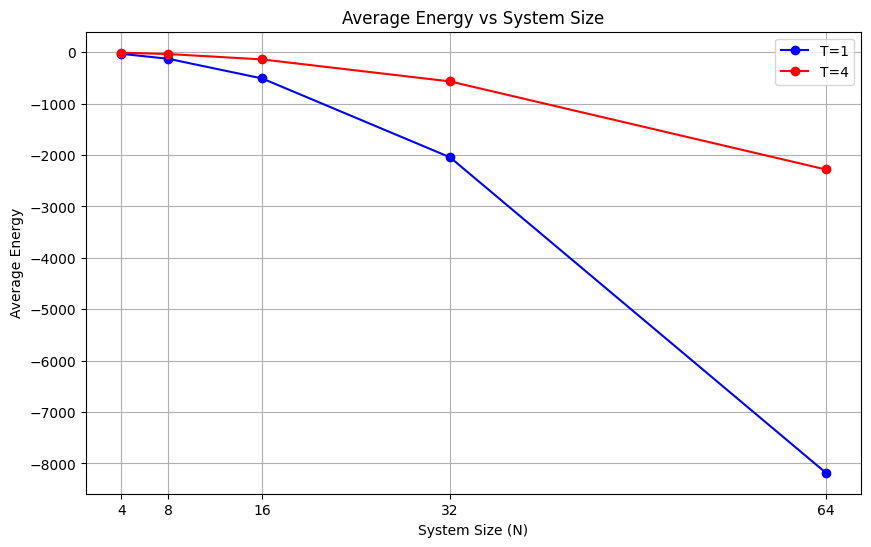

In [35]:
# plot energy vs system size
energies_T1 = [averages[(size, 1)][0] for size in system_sizes]
energies_T4 = [averages[(size, 4)][0] for size in system_sizes] 
plt.figure(figsize=(10, 6))
plt.plot(sizes_T1, energies_T1, marker='o', linestyle='-', color='b', label='T=1')
plt.plot(sizes_T4, energies_T4, marker='o', linestyle='-', color='r', label='T=4')
plt.title('Average Energy vs System Size')
plt.xlabel('System Size (N)')
plt.ylabel('Average Energy')
plt.xticks(system_sizes, system_sizes)
plt.legend()
plt.grid(True)
plt.show()

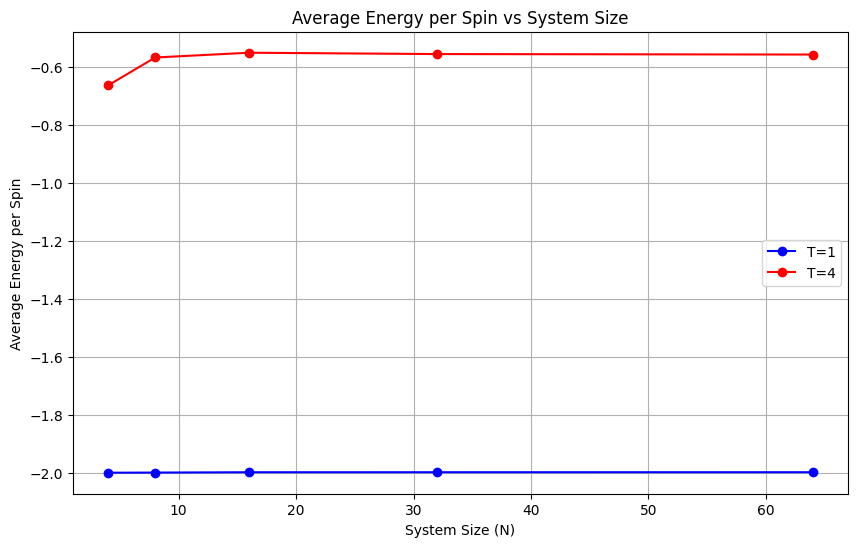

In [36]:
# plot energy per spin vs system size
energies_per_spin_T1 = [energies_T1[i]/(system_sizes[i]**2) for i in range(len(system_sizes))]
energies_per_spin_T4 = [energies_T4[i]/(system_sizes[i]**2) for i in range(len(system_sizes))]
plt.figure(figsize=(10, 6))
plt.plot(sizes_T1, energies_per_spin_T1, marker='o', linestyle='-', color='b', label='T=1')
plt.plot(sizes_T4, energies_per_spin_T4, marker='o', linestyle='-', color='r', label='T=4')
plt.title('Average Energy per Spin vs System Size')
plt.xlabel('System Size (N)')
plt.ylabel('Average Energy per Spin')
plt.legend()
plt.grid(True)
plt.show()

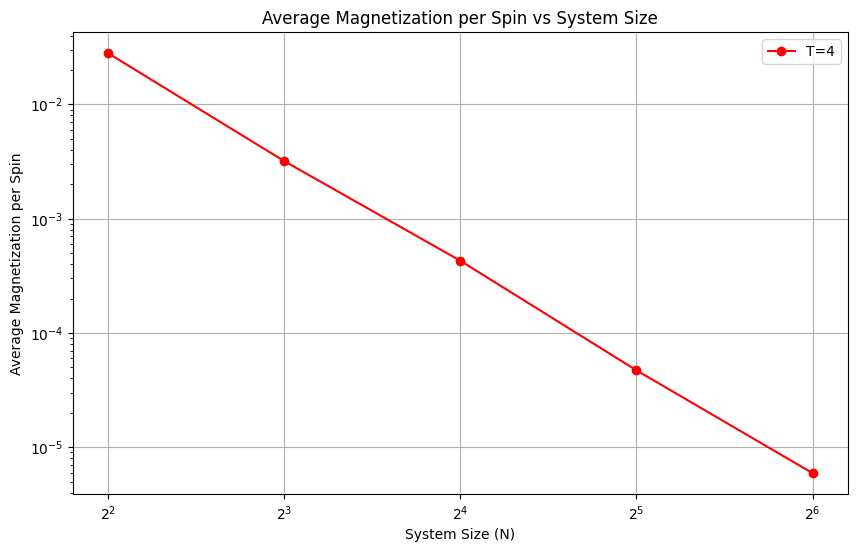

In [37]:
# plot average magnetization per spin vs system size
magnetizations_per_spin_T1 = [magnetizations_T1[i]/(system_sizes[i]**2) for i in range(len(system_sizes))]
magnetizations_per_spin_T4 = [magnetizations_T4[i]/(system_sizes[i]**2) for i in range(len(system_sizes))]
plt.figure(figsize=(10, 6)) 
# plt.plot(sizes_T1, magnetizations_per_spin_T1, marker='o', linestyle='-', color='b', label='T=1')
plt.plot(sizes_T4, magnetizations_per_spin_T4   , marker='o', linestyle='-', color='r', label='T=4')
plt.title('Average Magnetization per Spin vs System Size')
plt.xlabel('System Size (N)')
plt.yscale('log')
plt.xscale('log', base=2)
plt.ylabel('Average Magnetization per Spin')
plt.legend()
plt.grid(True)
plt.show()

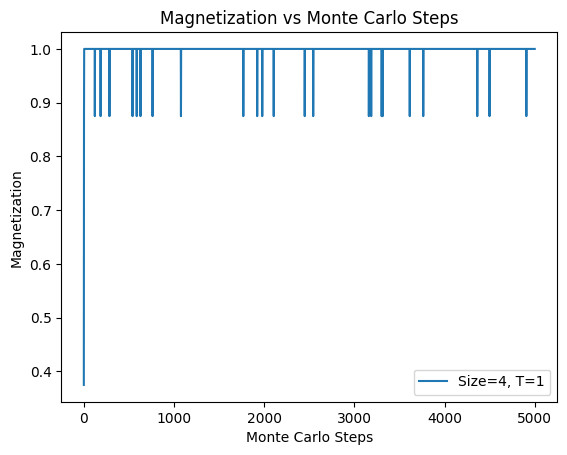

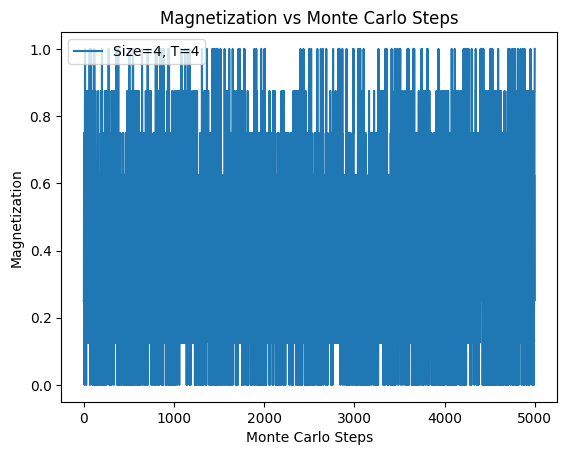

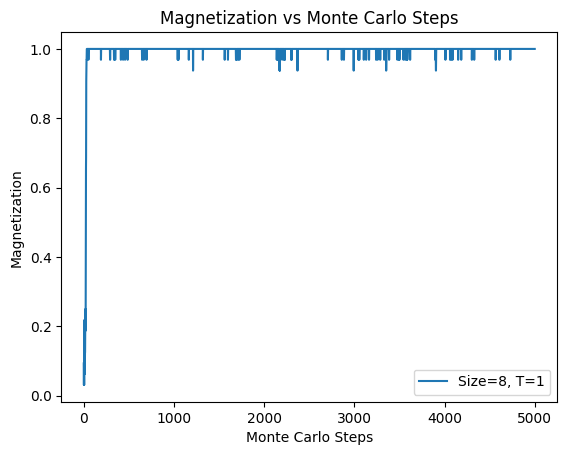

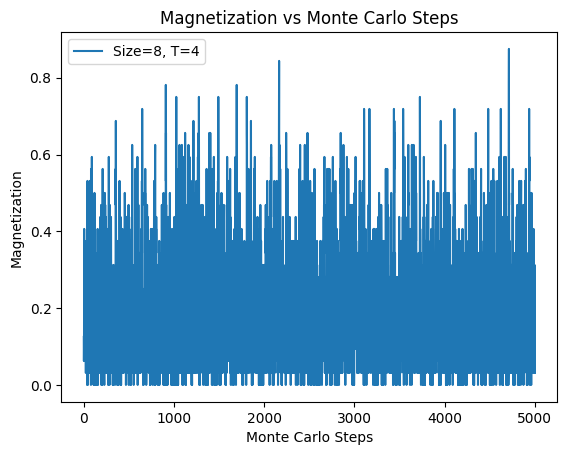

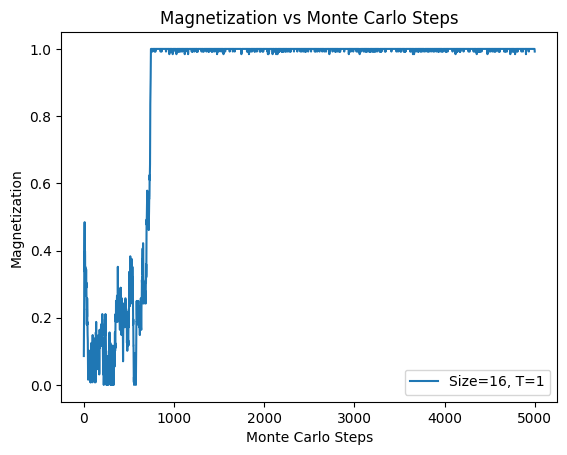

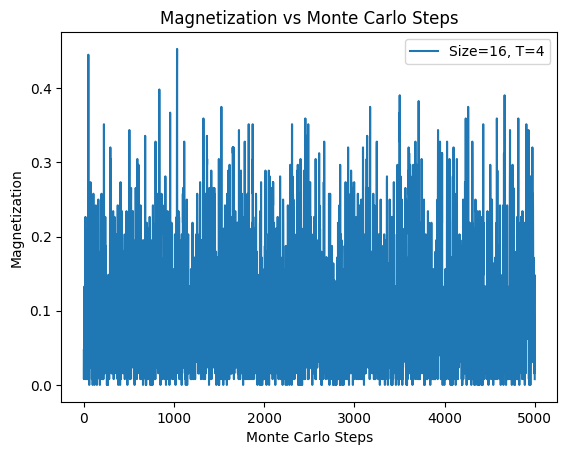

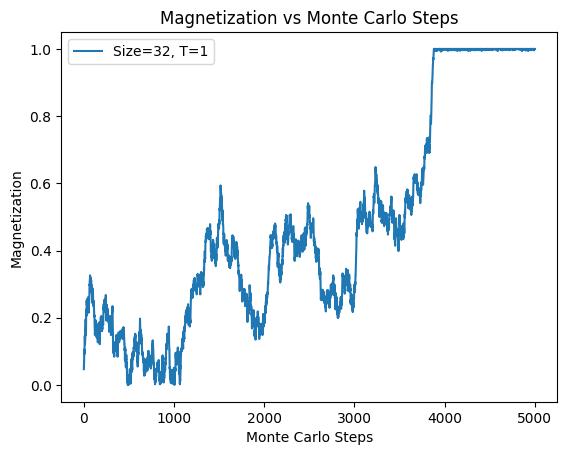

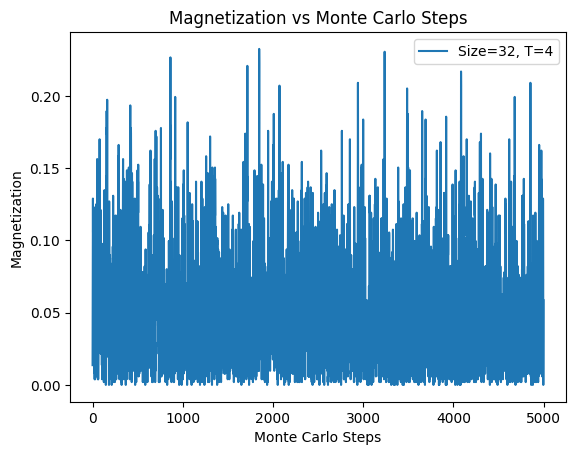

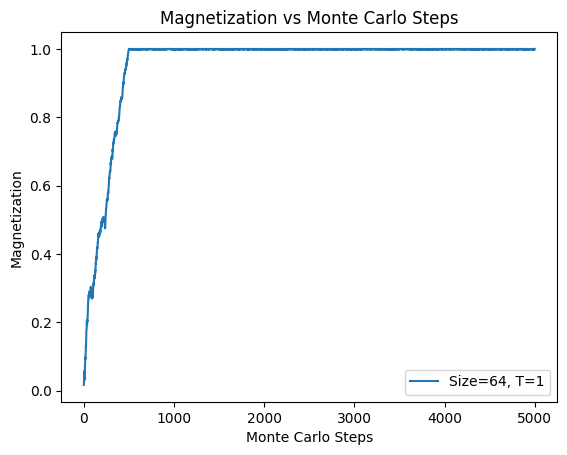

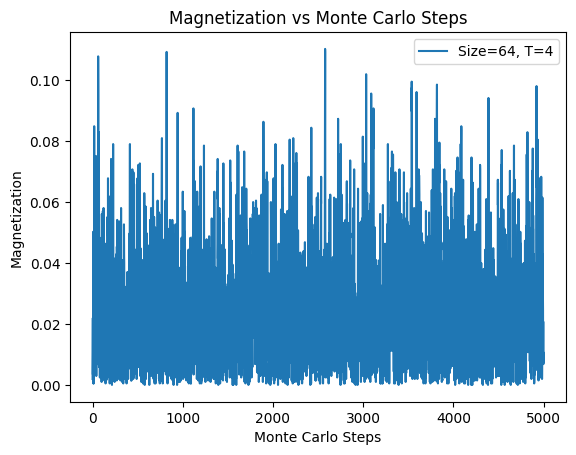

In [38]:
# plot all magnetization series
for size in system_sizes:
    for T in temps:
        steps = np.arange(len(series[(size, T)]))
        magnetizations = series[(size, T)][:, 1]
        plt.plot(steps, magnetizations, label=f'Size={size}, T={T}')
        plt.xlabel('Monte Carlo Steps')
        plt.ylabel('Magnetization')
        plt.title('Magnetization vs Monte Carlo Steps')
        plt.legend()
        plt.show()

        

In [41]:
def stable_index(
    series,
    w: int = 50,
    rtol: float = 0.01,
    atol: float = 0.0,
    confirm: int = 3,
    min_index: int = 0,
    robust_scale_percentiles = (5, 95),
) :
    """
    Detecta el primer índice donde la serie entra en una 'meseta':
    en una ventana de tamaño w, el rango (max - min) es pequeño.

    Parámetros:
      - series: iterable de floats (puede contener NaNs).
      - w: tamaño de la ventana deslizante.
      - rtol: tolerancia relativa (fracción de la escala robusta de la serie).
      - atol: tolerancia absoluta adicional (se suma a rtol*escala). Útil si los valores están cerca de 0.
      - confirm: cantidad de pasos consecutivos en los que la condición debe cumplirse.
      - min_index: índice mínimo a partir del cual empezar a buscar estabilidad.
      - robust_scale_percentiles: percentiles usados para estimar la escala robusta (p95 - p5).

    Retorna:
      - El índice (int) donde comienza la fase estable (inicio de la ventana que cumple) o None si no se detecta.
    """
    x = np.array(list(series), dtype=float)

    # Manejo de longitud insuficiente
    n = len(x)
    if n < max(w, 2):
        return None

    # Permitir NaNs: trabajamos con ventanas válidas
    # Escala robusta para tolerancia relativa
    finite_vals = x[np.isfinite(x)]
    if finite_vals.size == 0:
        return None

    p_low, p_high = robust_scale_percentiles
    lo = np.percentile(finite_vals, p_low)
    hi = np.percentile(finite_vals, p_high)
    scale = max(hi - lo, 1e-12)  # evitar cero

    band = atol + rtol * scale

    # aseguramos min_index razonable
    i = max(min_index, w - 1)
    consec = 0

    while i < n:
        # ventana [i-w+1, i]
        start = i - w + 1
        if start < 0:
            i += 1
            continue

        win = x[start:i+1]
        win = win[np.isfinite(win)]
        if win.size >= max(2, w // 2):  # exigir cierta cantidad válida
            rng = win.max() - win.min()
            if rng <= band:
                consec += 1
            else:
                consec = 0
        else:
            consec = 0

        if consec >= confirm:
            # reportamos el inicio de la primera ventana válida del bloque confirmado
            # El bloque confirmado termina en i, empezó en i - confirm + 1
            first_ok_i = i - confirm + 1
            start_idx = first_ok_i - w + 1
            return max(start_idx, 0)

        i += 1

    return None

In [43]:
# get all series for T = 1
all_stable_indices_T1 = {}
for size in system_sizes:
    stable_idx = stable_index(series[(size, 1)][:, 1], w=50, rtol=0.01, atol=0.0, confirm=3, min_index=0)
    all_stable_indices_T1[size] = stable_idx

print("Stable indices for T=1:", all_stable_indices_T1)


Stable indices for T=1: {4: 3, 8: 52, 16: 743, 32: 3879, 64: 496}
